In [1]:
import sys
import os

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

DOWNLOAD = False

if DOWNLOAD:
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)

## 0. Load data

In [2]:
path_to_data = '' 
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape

## 1. Prediction from pixels

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold

X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
X_val_scaled = scaler.fit_transform(X_val)

pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

X_train_pca.shape,X_val_pca.shape

((2592, 1000), (288, 1000))

### 1.1 Linear regression

In [4]:
lr = LinearRegression()
lr.fit(X_train_pca, spikes_train)

pearson_corr_lr = np.zeros(n_neurons)
predictions_val_lr = lr.predict(X_val_pca)
for i in range(n_neurons):
    pearson_corr_lr[i] = np.corrcoef(predictions_val_lr[:, i], spikes_val[:, i])[0, 1]
explained_var_lr = explained_variance_score(spikes_val, predictions_val_lr, multioutput='raw_values')

print("Linear Regression")
print("Pearson correlation: ", np.mean(pearson_corr_lr))
print("Explained variance: ", np.mean(explained_var_lr))

Linear Regression
Pearson correlation:  0.221168866209307
Explained variance:  -0.0724655691356886


### 1.2 Ridge regression

In [18]:
def find_best_alpha_ridge(X, y, candidate_alphas=None, n_splits=5, scoring='explained_variance'):
    """
    Perform k-fold cross-validation to find the best alpha for Ridge regression.

    Parameters:
        X (np.ndarray): Input features of shape (n_samples, n_features)
        y (np.ndarray): Target values of shape (n_samples, n_targets)
        candidate_alphas (list): List of alpha values to try
        n_splits (int): Number of cross-validation folds
        scoring (str): Metric to use ('explained_variance' or 'correlation')

    Returns:
        float: Best alpha value
    """
    if candidate_alphas is None:
        candidate_alphas = np.logspace(-2,5,5)

    best_alpha = None
    best_score = -np.inf

    for alpha in candidate_alphas:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=888)
        fold_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val_cv = y[train_idx], y[val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)

            if scoring == 'explained_variance':
                score = np.mean([
                    explained_variance_score(y_val_cv[:, n], preds[:, n])
                    for n in range(y.shape[1])
                ])
            elif scoring == 'correlation':
                score = np.mean([
                    np.corrcoef(preds[:, n], y_val_cv[:, n])[0, 1]
                    for n in range(y.shape[1])
                ])
            else:
                raise ValueError("Invalid scoring. Use 'explained_variance' or 'correlation'.")

            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        print(f"Alpha {alpha:.1e} -> CV {scoring}: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha

    print(f"✅ Best alpha: {best_alpha:.1e} with CV {scoring}: {best_score:.4f}")
    return best_alpha


In [6]:
best_alpha = find_best_alpha_ridge(X_train_pca, spikes_train, candidate_alphas=None, n_splits=5, scoring='explained_variance')
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_pca, spikes_train)
predictions_val_ridge = ridge.predict(X_val_pca)
pearson_corr_ridge = np.zeros(n_neurons)
for i in range(n_neurons):
    pearson_corr_ridge[i] = np.corrcoef(predictions_val_ridge[:, i], spikes_val[:, i])[0, 1]
explained_var_ridge = explained_variance_score(spikes_val, predictions_val_ridge, multioutput='raw_values')
print("Ridge Regression")
print("Pearson correlation: ", np.mean(pearson_corr_ridge))
print("Explained variance: ", np.mean(explained_var_ridge))

Alpha 1.0e-02 -> CV explained_variance: -1.3631
Alpha 5.6e-01 -> CV explained_variance: -1.3627
Alpha 3.2e+01 -> CV explained_variance: -1.3410
Alpha 1.8e+03 -> CV explained_variance: -0.7186
Alpha 1.0e+05 -> CV explained_variance: 0.0600
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.0600
Ridge Regression
Pearson correlation:  0.2739008283023446
Explained variance:  0.08147349208593369


### 1.3 Brief conclusion
Ridge regression performs slightly better than naive linear regression. Hence we established our regression model: after extracting first 1000 PCs, then perform Ridge regression with the best alpha value found by grid search.

## 2. Task-driven approach

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_validate,KFold
from tqdm import tqdm
import gc
import pickle
from torch.nn import init
from torch.nn import Parameter
# import pandas as pd
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

y_train = spikes_train
y_val = spikes_val

In [4]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")

PyTorch version: 2.7.0+cu118
CUDA available: Yes
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4090 Laptop GPU


### 2.1 Define functions to extract layer activation

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))

    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook

    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

In [6]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

def extract_features(model, stimulus, layers_to_extract, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()

    results = {}

    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")

        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Collect activations
        layer_activations = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()

                # Flatten
                if len(layer_act.shape) > 2:
                    if layer_name == 'avgpool':
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                    else:
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)

                layer_activations.append(layer_act)

        # Combine batches
        layer_act = np.vstack(layer_activations)

        # Store original features
        results[layer_name] = {
            'features': layer_act
        }

        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()

    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()

    return results

def apply_pca_to_features(train_features, val_features, layers_to_extract, n_components=1000):
    train_pcs = {}
    val_pcs = {}

    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']

        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue

        # if the data hasnt been scaled
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_val_scaled = scaler.transform(X_val) 
        X_train_scaled = X_train
        X_val_scaled = X_val

        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            # 'scaler': scaler,
            'pca': pca
        }

        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val)
        }

        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")

    return train_pcs, val_pcs

### 2.2 Initialize pretrained model

In [7]:
need_to_extract_pca = "True"
# What model you want to use?
# resnet18, resnet50, vit or random for unpretrained model
my_model = "resnet50"
# my_model = "alexnet"
# my_model = "mobilenet"
# my_model = "vgg16"
# my_model = "vit"
# my_model = "resnet18"
# my_model = "random"

In [8]:
# =============================
# Model Selection Block (MobileNetV2, VGG16, AlexNet, DenseNet121, ResNet18, ViT)
# =============================
from torchvision.models import (
    mobilenet_v2, vgg16, alexnet, densenet121,
    resnet18, vit_b_16,resnet50
)

device = "cuda" if torch.cuda.is_available() else "cpu"

if my_model == "mobilenet":
    print("Using MobileNetV2 pretrained model")
    pretrained_model = mobilenet_v2(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',
        'features.3',
        'features.6',
        'features.10',
        'features.14',
        'features.18',
    ]

elif my_model == "vgg16":
    print("Using VGG16 pretrained model")
    pretrained_model = vgg16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.4',
        'features.9',
        'features.16',  
        'features.23',  
        'features.30'  
    ]

elif my_model == "alexnet":
    print("Using AlexNet pretrained model")
    pretrained_model = alexnet(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',   # conv1
        'features.2',
        'features.5',
        'features.12'
    ]


elif my_model == "resnet18":
    print("Using ResNet18 pretrained model")
    pretrained_model = resnet18(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "resnet50":
    print("Using ResNet50 pretrained model")
    pretrained_model = resnet50(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "vit":
    print("Using Vision Transformer (ViT-B/16) pretrained model")
    pretrained_model = vit_b_16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    # ViT has a flat structure, so just one key representation layer
    layers_to_extract = [
        'conv_proj',
        'encoder',
        'heads',
    ]
    
elif my_model == "random":
    print("Using Randomly Initialized Model")
    random_model = resnet50(pretrained=False)
    random_model.to(device)
    random_model.eval()
    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

else:
    raise ValueError("Unsupported model type. Choose from: 'pretrained', 'vgg16', 'alexnet', 'densenet', 'resnet', 'vit'")


Using ResNet50 pretrained model


/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.3 (Optional) Fine-tune pretrained Model
Use pretrained ResNet50 to fine-tune.

#### 2.3.1 Preparation
Encode fine-tuning labels，get the pretrained model and load the data.

In [9]:
# Encoding of the labels
y_ft_train = objects_train
y_ft_val = objects_val
unique_classes = sorted(list(set(y_ft_train) | set(y_ft_val)))
num_classes = len(unique_classes)
print(f"Number of unique classes: {num_classes}")
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
y_ft_train = np.array([class_to_idx[cls] for cls in objects_train])
y_ft_val = np.array([class_to_idx[cls] for cls in objects_val])

Number of unique classes: 64


In [11]:
model_name = "resnet50" # only resnet50 for now
resnet50 = getattr(models, model_name)(weights='IMAGENET1K_V1')
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, num_classes)  

resnet50.eval()  # Set to evaluation mode
resnet50 = resnet50.to(device)

In [12]:
# Define batch size
batch_size = 128

# Create training dataset and dataloader
train_dataset = TensorDataset(
    preprocess_images(stimulus_train), 
    torch.tensor(y_ft_train, dtype=torch.long)
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

# Create evaluation dataset and dataloader
eval_dataset = TensorDataset(
    preprocess_images(stimulus_val), 
    torch.tensor(y_ft_val, dtype=torch.long)
)
eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

#### 2.3.2 Training

In [10]:
def train_model(model, train_dataloader, eval_dataloader, y_train, y_val, criterion,
                num_epochs, device, warmup_epochs=2, lr_start=0.001, lr_max=0.01, lr_min=0.000001,
                patience=30, min_delta=0.001):
    # Lists to store metrics
    train_losses = []
    val_accuracies = []
    
    # Initialize optimizer with starting learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)
    
    # Use a more aggressive learning rate scheduler
    # ReduceLROnPlateau reduces LR when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,     # Reduce LR by half when triggered
        patience=5,     # Number of epochs with no improvement after which LR will be reduced
        min_lr=lr_min
    )
    
    # Early stopping variables
    best_val_mse = float('inf')
    counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        
        with torch.no_grad():
            all_preds = []
            total_mse = 0.0
            num_batches = 0
            
            for inputs, targets in eval_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate MSE
                batch_mse = criterion(outputs, targets).item()
                total_mse += batch_mse
                num_batches += 1
                
                # Store predictions for further analysis if needed
                all_preds.append(outputs.cpu().numpy())
                
        # Calculate average MSE over all validation batches
        val_mse = total_mse / num_batches
        val_accuracies.append(-val_mse)  # Store negative MSE so higher is better in plots
        
        # Step the scheduler based on validation loss
        scheduler.step(val_mse)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}, Loss: {epoch_loss:.4f}, Validation MSE: {val_mse:.4f}')
        
        # Early stopping check
        if val_mse < best_val_mse - min_delta:
            best_val_mse = val_mse
            counter = 0
            # Save the best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Load the best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
    
    return train_losses, val_accuracies


In [14]:
criterion = nn.CrossEntropyLoss()
num_epochs = 1000
train_losses, val_accuracies = train_model(
    model=resnet50,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    y_train=y_ft_train,
    y_val=y_ft_val,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=20
)

Epoch 1/1000, LR: 0.001000, Loss: 2.5393, Validation MSE: 3.2584
Epoch 2/1000, LR: 0.001000, Loss: 1.2415, Validation MSE: 2.4097
Epoch 3/1000, LR: 0.001000, Loss: 0.8891, Validation MSE: 1.8847
Epoch 4/1000, LR: 0.001000, Loss: 0.7673, Validation MSE: 1.4324
Epoch 5/1000, LR: 0.001000, Loss: 0.5217, Validation MSE: 1.2174
Epoch 6/1000, LR: 0.001000, Loss: 0.4052, Validation MSE: 1.0409
Epoch 7/1000, LR: 0.001000, Loss: 0.4704, Validation MSE: 2.9335
Epoch 8/1000, LR: 0.001000, Loss: 0.4358, Validation MSE: 1.5487
Epoch 9/1000, LR: 0.001000, Loss: 0.3460, Validation MSE: 1.8774
Epoch 10/1000, LR: 0.001000, Loss: 0.1957, Validation MSE: 1.1776
Epoch 11/1000, LR: 0.001000, Loss: 0.1477, Validation MSE: 2.3227
Epoch 12/1000, LR: 0.000500, Loss: 0.1934, Validation MSE: 1.6935
Epoch 13/1000, LR: 0.000500, Loss: 0.1234, Validation MSE: 0.6754
Epoch 14/1000, LR: 0.000500, Loss: 0.0706, Validation MSE: 0.5166
Epoch 15/1000, LR: 0.000500, Loss: 0.0359, Validation MSE: 0.5351
Epoch 16/1000, LR: 

In [17]:
filename = "resnet50_fpft_classification.pth" 
print("Selected model name is ", filename)
torch.save(resnet50.state_dict(), filename)
print(f"Model saved successfully to {filename}")
pretrained_model = resnet50
use_fpft = True

Selected model name is  resnet50_fpft_classification.pth
Model saved successfully to resnet50_fpft_classification.pth


#### 2.3.3 Load fine-tuned model if exists

In [25]:
 # load it from shared drive
filename = "resnet50_fpft_classification.pth"

pretrained_model = getattr(models, "resnet50")(weights='IMAGENET1K_V1')
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, num_classes)
pretrained_model = pretrained_model.to(device)

# Load the saved state dict
pretrained_model.load_state_dict(torch.load(filename))
pretrained_model.eval()
pretrained_model = pretrained_model.to(device)
print(f"Model loaded successfully from '{filename}'")
use_fpft = True

Model loaded successfully from 'resnet50_fpft_classification.pth'


### 2.4 Obtain activation and perform PCA per layer

In [19]:
need_to_extract_pca # if you dont have the pcs file, train it (its very large)

'True'

In [20]:
if need_to_extract_pca=="True":
    if my_model != "random":
        print("Extracting features from pre-trained model...")
        pretrained_features_train = extract_features(pretrained_model, stimulus_train, layers_to_extract, batch_size=64)
        pretrained_features_val = extract_features(pretrained_model, stimulus_val, layers_to_extract, batch_size=64)
    else:
        print("Extracting features from randomly initialized model...")
        random_features_train = extract_features(random_model, stimulus_train, layers_to_extract, batch_size=64)
        random_features_val = extract_features(random_model, stimulus_val, layers_to_extract, batch_size=64)
else:
    print("No need to extract features")

Extracting features from pre-trained model...

Processing layer: conv1


Extracting conv1: 100%|██████████| 41/41 [00:05<00:00,  6.95it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 41/41 [00:07<00:00,  5.77it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 41/41 [00:04<00:00,  9.52it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 41/41 [00:04<00:00,  9.05it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 41/41 [00:03<00:00, 11.18it/s]



Processing layer: conv1


Extracting conv1: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 5/5 [00:00<00:00,  7.11it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 5/5 [00:00<00:00, 14.09it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


In [21]:
if need_to_extract_pca == "True":
    print(f"Extracting PCA from {my_model} model...")
    #if my_model == "pretrained":
    if my_model != "random":
        pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            pretrained_features_train,
            pretrained_features_val,
            layers_to_extract,
            n_components=1000
        )
    else:
        random_pcs_train, random_pcs_val = apply_pca_to_features(
            random_features_train,
            random_features_val,
            layers_to_extract,
            n_components=1000
        )
else:
    print("No need to extract PCA from features")

Extracting PCA from resnet50 model...
Layer conv1: 1000 components, 0.9368 variance explained
Layer layer1: 1000 components, 0.7126 variance explained
Layer layer2: 1000 components, 0.6933 variance explained
Layer layer3: 1000 components, 0.7644 variance explained
Layer layer4: 1000 components, 0.9861 variance explained


In [22]:
# # pca_name = "fpft_pretrained_scaled_pcs.pkl" if already_scaled else "fpft_pretrained_pcs.pkl"
# pca_name = "restnet50_fpft_classification_pcs.pkl"
# print("Loading PCA results...")
# with open(pca_name, 'rb') as f:
#     pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)

In [11]:
def find_best_alpha_ridge(X, y, candidate_alphas=None, n_splits=5, scoring='explained_variance'):
    """
    Perform k-fold cross-validation to find the best alpha for Ridge regression.

    Parameters:
        X (np.ndarray): Input features of shape (n_samples, n_features)
        y (np.ndarray): Target values of shape (n_samples, n_targets)
        candidate_alphas (list): List of alpha values to try
        n_splits (int): Number of cross-validation folds
        scoring (str): Metric to use ('explained_variance' or 'correlation')

    Returns:
        float: Best alpha value
    """
    if candidate_alphas is None:
        candidate_alphas = np.logspace(-2,5,5)

    best_alpha = None
    best_score = -np.inf

    for alpha in candidate_alphas:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=888)
        fold_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val_cv = y[train_idx], y[val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)

            if scoring == 'explained_variance':
                score = np.mean([
                    explained_variance_score(y_val_cv[:, n], preds[:, n])
                    for n in range(y.shape[1])
                ])
            elif scoring == 'correlation':
                score = np.mean([
                    np.corrcoef(preds[:, n], y_val_cv[:, n])[0, 1]
                    for n in range(y.shape[1])
                ])
            else:
                raise ValueError("Invalid scoring. Use 'explained_variance' or 'correlation'.")

            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        print(f"Alpha {alpha:.1e} -> CV {scoring}: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha

    print(f"✅ Best alpha: {best_alpha:.1e} with CV {scoring}: {best_score:.4f}")
    return best_alpha


In [12]:
def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}

    for layer_name in layers_to_extract:
        print(f"Predicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']


        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")

        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample

        best_alpha = find_best_alpha_ridge(X_train_pcs, y_train, candidate_alphas=np.logspace(-2,5,10), n_splits=5, scoring='explained_variance')
        lr = Ridge(alpha=best_alpha)
        lr.fit(X_train_pcs, y_train)

        y_pred = lr.predict(X_val_pcs)
        y_true = y_val

            # Calculate correlation and explained variance
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            correlation = np.corrcoef(y_pred[:,neuron], y_true[:,neuron])[0, 1]
            exp_var = explained_variance_score(y_true[:,neuron], y_pred[:,neuron])

            correlations.append(correlation)
            exp_variances.append(exp_var)

            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot,neuron])

        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }

        sample_predictions[layer_name] = np.array(sample_neuron_predictions)

        print(f"Mean correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho

    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))

    plt.figure(figsize=(14, 7))
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)

    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-', color=colors[i], label=f'{layer_name} Prediction', alpha=0.8)

    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()

    return layer_metrics

Predicting with pre-trained model features...
Predicting neural activity using conv1
Alpha 1.0e-02 -> CV explained_variance: -1.3210
Alpha 6.0e-02 -> CV explained_variance: -1.3210
Alpha 3.6e-01 -> CV explained_variance: -1.3210
Alpha 2.2e+00 -> CV explained_variance: -1.3210
Alpha 1.3e+01 -> CV explained_variance: -1.3206
Alpha 7.7e+01 -> CV explained_variance: -1.3186
Alpha 4.6e+02 -> CV explained_variance: -1.3068
Alpha 2.8e+03 -> CV explained_variance: -1.2397
Alpha 1.7e+04 -> CV explained_variance: -0.9437
Alpha 1.0e+05 -> CV explained_variance: -0.3447
✅ Best alpha: 1.0e+05 with CV explained_variance: -0.3447


Training models for conv1: 100%|██████████| 168/168 [00:00<00:00, 2813.52it/s]

Mean correlation for conv1: 0.2422
Mean explained variance for conv1: -0.0012
Predicting neural activity using layer1


Alpha 1.0e-02 -> CV explained_variance: -0.5464
Alpha 6.0e-02 -> CV explained_variance: -0.5464
Alpha 3.6e-01 -> CV explained_variance: -0.5462
Alpha 2.2e+00 -> CV explained_variance: -0.5451
Alpha 1.3e+01 -> CV explained_variance: -0.5383
Alpha 7.7e+01 -> CV explained_variance: -0.4998
Alpha 4.6e+02 -> CV explained_variance: -0.3294
Alpha 2.8e+03 -> CV explained_variance: 0.0324
Alpha 1.7e+04 -> CV explained_variance: 0.2443
Alpha 1.0e+05 -> CV explained_variance: 0.1922
✅ Best alpha: 1.7e+04 with CV explained_variance: 0.2443


Training models for layer1: 100%|██████████| 168/168 [00:00<00:00, 3200.25it/s]

Mean correlation for layer1: 0.5155
Mean explained variance for layer1: 0.2724
Predicting neural activity using layer2


Alpha 1.0e-02 -> CV explained_variance: -0.2881
Alpha 6.0e-02 -> CV explained_variance: -0.2880
Alpha 3.6e-01 -> CV explained_variance: -0.2878
Alpha 2.2e+00 -> CV explained_variance: -0.2865
Alpha 1.3e+01 -> CV explained_variance: -0.2788
Alpha 7.7e+01 -> CV explained_variance: -0.2362
Alpha 4.6e+02 -> CV explained_variance: -0.0671
Alpha 2.8e+03 -> CV explained_variance: 0.2059
Alpha 1.7e+04 -> CV explained_variance: 0.2684
Alpha 1.0e+05 -> CV explained_variance: 0.1498
✅ Best alpha: 1.7e+04 with CV explained_variance: 0.2684


Training models for layer2: 100%|██████████| 168/168 [00:00<00:00, 3229.74it/s]

Mean correlation for layer2: 0.5425
Mean explained variance for layer2: 0.2830
Predicting neural activity using layer3


Alpha 1.0e-02 -> CV explained_variance: -0.1441
Alpha 6.0e-02 -> CV explained_variance: -0.1439
Alpha 3.6e-01 -> CV explained_variance: -0.1429
Alpha 2.2e+00 -> CV explained_variance: -0.1366
Alpha 1.3e+01 -> CV explained_variance: -0.1016
Alpha 7.7e+01 -> CV explained_variance: 0.0421
Alpha 4.6e+02 -> CV explained_variance: 0.2809
Alpha 2.8e+03 -> CV explained_variance: 0.3422
Alpha 1.7e+04 -> CV explained_variance: 0.2376
Alpha 1.0e+05 -> CV explained_variance: 0.0973
✅ Best alpha: 2.8e+03 with CV explained_variance: 0.3422


Training models for layer3: 100%|██████████| 168/168 [00:00<00:00, 2541.07it/s]

Mean correlation for layer3: 0.6087
Mean explained variance for layer3: 0.3694
Predicting neural activity using layer4


Alpha 1.0e-02 -> CV explained_variance: -0.3826
Alpha 6.0e-02 -> CV explained_variance: -0.3826
Alpha 3.6e-01 -> CV explained_variance: -0.3823
Alpha 2.2e+00 -> CV explained_variance: -0.3804
Alpha 1.3e+01 -> CV explained_variance: -0.3695
Alpha 7.7e+01 -> CV explained_variance: -0.3109
Alpha 4.6e+02 -> CV explained_variance: -0.0958
Alpha 2.8e+03 -> CV explained_variance: 0.2018
Alpha 1.7e+04 -> CV explained_variance: 0.3115
Alpha 1.0e+05 -> CV explained_variance: 0.3060
✅ Best alpha: 1.7e+04 with CV explained_variance: 0.3115


Training models for layer4: 100%|██████████| 168/168 [00:00<00:00, 2457.32it/s]

Mean correlation for layer4: 0.5978
Mean explained variance for layer4: 0.3695


<Figure size 1400x700 with 0 Axes>

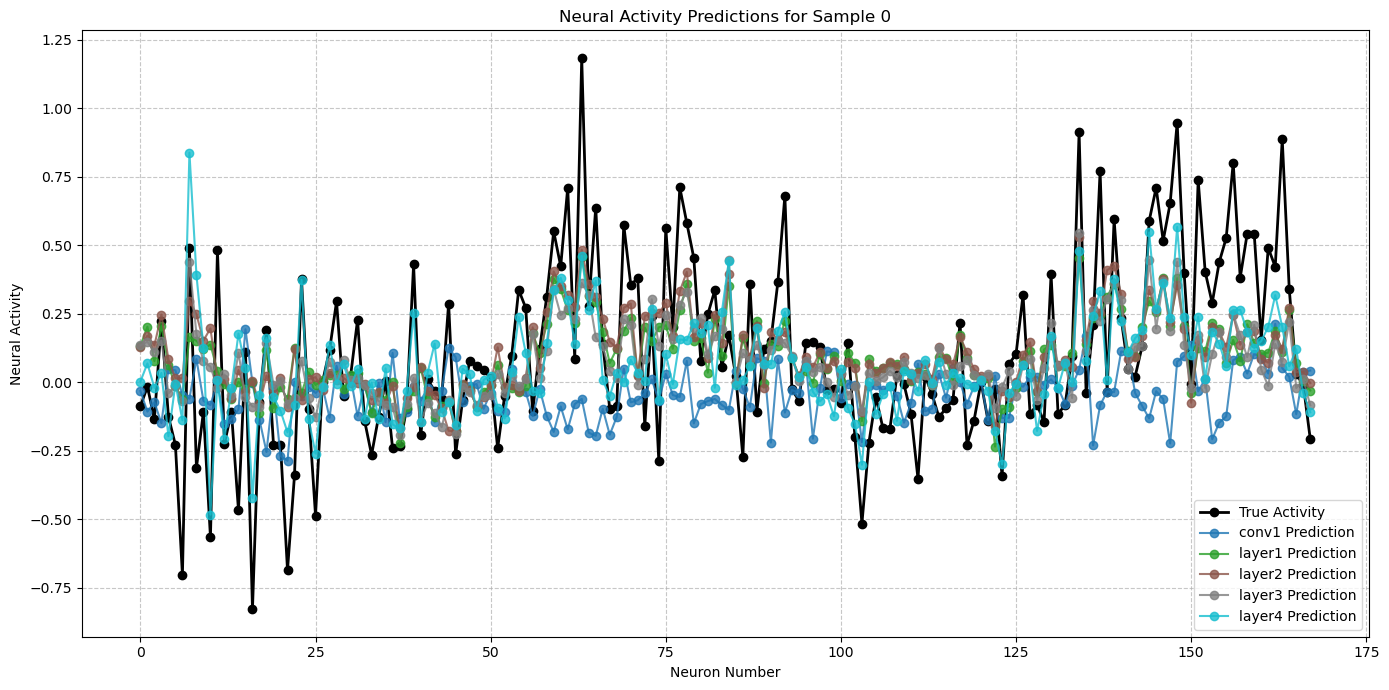

In [24]:
#if my_model == "pretrained":
if my_model != "random":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val)

In [14]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.generic):
            return obj.item()
        return super().default(obj)

In [32]:
if use_fpft:
    filename = f"{my_model}_fpft_classification_layer_metrics.json"
else:
    filename = f"{my_model}_layer_metrics.json"
print(f"saving to {filename}")


with open(filename, "w") as f:
    json.dump(layer_metrics, f, cls=NumpyEncoder, indent=2)

saving to resnet50_fpft_classification_layer_metrics.json


## 3. Data-driven aproach

### 3.1 Define dataloader for training

In [33]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [34]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)

### 3.2. Build shallow CNN for strike prediction

In [35]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod 
    @torch.no_grad() 
    def init_weights(module):
        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [36]:
class ToyMobilenet(nn.Module):
    def __init__(self, num_neuron):
        super(ToyMobilenet, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(16, 32, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32),

            # First Inverted Residual Block
            nn.Conv2d(32, 64, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 32, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(32),

            # Convolutional Block 4 (downsampling to 16x16)
            nn.Conv2d(32, 64, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            # Convolutional Block 5
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),

            # Convolutional Block 6
            nn.Conv2d(128, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),

            # Second Inverted Residual Block
            nn.Conv2d(128, 256, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(128),

            # Final Expansion and Projection Layer
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, num_neuron)
        )

    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad()
    def init_weights(module):
        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

### 3.3. Train models

In [51]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for stimulus, spikes in train_loader:
            stimulus, spikes = stimulus.to(device), spikes.to(device)
            optimizer.zero_grad()

            outputs = model(stimulus)
            loss = criterion(outputs, spikes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss/len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)

    return model

In [52]:
loss_fn = nn.MSELoss()
my_model = "shallowcnn" # or toymobilenet
if my_model == "shallowcnn":
    model = ShallowCNN(num_neuron=n_neurons)
    model.apply(ShallowCNN.init_weights)
elif my_model == "toymobilenet":
    model = ToyMobilenet(num_neuron=n_neurons)
    model.apply(ToyMobilenet.init_weights)
else:
    raise ValueError("Unsupported model type. Choose from: 'shallowcnn', 'toymobilenet'")

model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
if my_model == "toymobilenet":
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
else:
    scheduler = None
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=100, scheduler=scheduler)

if my_model == "shallowcnn":
    save_path = 'shallow_cnn.pth'
elif my_model == "toymobilenet":
    save_path = 'toy_mobilenet.pth'
    

torch.save(model.state_dict(), save_path)

Epoch 1/100, Train Loss: 1256.0723, Val Loss: 53.8814
Epoch 2/100, Train Loss: 55.5749, Val Loss: 17.7943
Epoch 3/100, Train Loss: 31.1179, Val Loss: 12.0998
Epoch 4/100, Train Loss: 22.4832, Val Loss: 9.1956
Epoch 5/100, Train Loss: 16.8963, Val Loss: 7.1869
Epoch 6/100, Train Loss: 13.8466, Val Loss: 6.2850
Epoch 7/100, Train Loss: 11.7592, Val Loss: 5.0918
Epoch 8/100, Train Loss: 9.7778, Val Loss: 4.5296
Epoch 9/100, Train Loss: 8.4679, Val Loss: 4.0702
Epoch 10/100, Train Loss: 7.6268, Val Loss: 3.6276
Epoch 11/100, Train Loss: 6.5383, Val Loss: 3.3986
Epoch 12/100, Train Loss: 5.8883, Val Loss: 2.9012
Epoch 13/100, Train Loss: 5.1485, Val Loss: 2.4596
Epoch 14/100, Train Loss: 4.7770, Val Loss: 2.4409
Epoch 15/100, Train Loss: 4.4672, Val Loss: 2.3640
Epoch 16/100, Train Loss: 4.0790, Val Loss: 2.1499
Epoch 17/100, Train Loss: 3.7293, Val Loss: 2.1898
Epoch 18/100, Train Loss: 3.5354, Val Loss: 2.1098
Epoch 19/100, Train Loss: 3.3092, Val Loss: 1.9361
Epoch 20/100, Train Loss: 3.

### 3.4. Evaluation of the model

In [53]:
load = True
load_path = 'shallow_cnn.pth'
my_model = "shallowcnn" # or toymobilenet

if load:
    if my_model == "shallowcnn":
        model = ShallowCNN(num_neuron=n_neurons)
    elif my_model == "toymobilenet":
        model = ToyMobilenet(num_neuron=n_neurons)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [54]:
model.eval()

prediction_train = []

ITdataloader_train2 = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train2:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)


prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)


In [55]:
pearson_corr_dd = np.zeros(n_neurons)
for i in range(n_neurons):
    pearson_corr_dd[i] = np.corrcoef(prediction_val[:, i], spikes_val[:, i])[0, 1]
explained_var_dd = explained_variance_score(spikes_val, prediction_val, multioutput='raw_values')
print(f"Data-driven model: {my_model}")
print("Pearson correlation: ", np.mean(pearson_corr_dd))
print("Explained variance: ", np.mean(explained_var_dd))

Data-driven model: shallowcnn
Pearson correlation:  0.03509916168182854
Explained variance:  -1.3150562


In [56]:
dd_metrics = {
    'correlations': pearson_corr_dd.tolist(),
    'exp_variances': explained_var_dd.tolist(),
    'mean_correlation': np.mean(pearson_corr_dd),
    'mean_exp_variance': np.mean(explained_var_dd)
}

filename = "dd_metrics.json"
with open(filename, "w") as f:
    json.dump(dd_metrics, f, cls=NumpyEncoder, indent=2)

## 4. Hybrid Method
Use pretrained ResNet50 to predict neural activity directly.

In [15]:
model_name = "resnet50"
resnet50 = getattr(models, model_name)(weights='IMAGENET1K_V1')

num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, n_neurons)  

resnet50.eval()  # Set to evaluation mode
resnet50 = resnet50.to(device)

In [16]:
batch_size = 128

# Create training dataset and dataloader
train_dataset = TensorDataset(
    preprocess_images(stimulus_train), 
    torch.tensor(y_train, dtype=torch.float32)
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

# Create evaluation dataset and dataloader
eval_dataset = TensorDataset(
    preprocess_images(stimulus_val), 
    torch.tensor(y_val, dtype=torch.float32)
)
eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

In [17]:
def train_model(model, train_dataloader, eval_dataloader, y_train, y_val, criterion,
                num_epochs, device, warmup_epochs=2, lr_start=0.001, lr_max=0.01, lr_min=0.000001,
                patience=50, min_delta=0.001):
    # Lists to store metrics
    train_losses = []
    val_accuracies = []
    
    # Initialize optimizer with starting learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)
    
    # Use a more aggressive learning rate scheduler
    # ReduceLROnPlateau reduces LR when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,     # Reduce LR by half when triggered
        patience=5,     # Number of epochs with no improvement after which LR will be reduced
        min_lr=lr_min
    )
    
    # Early stopping variables
    best_val_mse = float('inf')
    counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        
        with torch.no_grad():
            all_preds = []
            total_mse = 0.0
            num_batches = 0
            
            for inputs, targets in eval_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate MSE
                batch_mse = criterion(outputs, targets).item()
                total_mse += batch_mse
                num_batches += 1
                
                # Store predictions for further analysis if needed
                all_preds.append(outputs.cpu().numpy())
                
        # Calculate average MSE over all validation batches
        val_mse = total_mse / num_batches
        val_accuracies.append(-val_mse)  # Store negative MSE so higher is better in plots
        
        # Step the scheduler based on validation loss
        scheduler.step(val_mse)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}, Loss: {epoch_loss:.4f}, Validation MSE: {val_mse:.4f}')
        
        # Early stopping check
        if val_mse < best_val_mse - min_delta:
            best_val_mse = val_mse
            counter = 0
            # Save the best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Load the best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
    
    return train_losses, val_accuracies


In [18]:
criterion = nn.MSELoss()
num_epochs = 1000

train_losses, val_accuracies = train_model(
    model=resnet50,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    y_train=y_train,
    y_val=y_val,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=20
)

Epoch 1/1000, LR: 0.001000, Loss: 0.1599, Validation MSE: 0.2275
Epoch 2/1000, LR: 0.001000, Loss: 0.1130, Validation MSE: 0.1375
Epoch 3/1000, LR: 0.001000, Loss: 0.1030, Validation MSE: 0.1100
Epoch 4/1000, LR: 0.001000, Loss: 0.0930, Validation MSE: 0.0973
Epoch 5/1000, LR: 0.001000, Loss: 0.0846, Validation MSE: 0.0956
Epoch 6/1000, LR: 0.001000, Loss: 0.0771, Validation MSE: 0.0863
Epoch 7/1000, LR: 0.001000, Loss: 0.0718, Validation MSE: 0.0807
Epoch 8/1000, LR: 0.001000, Loss: 0.0653, Validation MSE: 0.0791
Epoch 9/1000, LR: 0.001000, Loss: 0.0608, Validation MSE: 0.0901
Epoch 10/1000, LR: 0.001000, Loss: 0.0571, Validation MSE: 0.0823
Epoch 11/1000, LR: 0.001000, Loss: 0.0541, Validation MSE: 0.0744
Epoch 12/1000, LR: 0.001000, Loss: 0.0510, Validation MSE: 0.0736
Epoch 13/1000, LR: 0.001000, Loss: 0.0492, Validation MSE: 0.0748
Epoch 14/1000, LR: 0.001000, Loss: 0.0461, Validation MSE: 0.0728
Epoch 15/1000, LR: 0.001000, Loss: 0.0445, Validation MSE: 0.0707
Epoch 16/1000, LR: 

In [24]:
filename = "resnet50_fpft_spike.pth"
torch.save(resnet50.state_dict(), filename)
print(f"Model saved successfully to {filename}")

Model saved successfully to resnet50_fpft_spike.pth


In [25]:
# Load
resnet50.load_state_dict(torch.load(filename))
resnet50.eval()  # Set the model to evaluation mode
print(f"Model loaded successfully from '{filename}'")

Model loaded successfully from 'resnet50_fpft_spike.pth'


In [26]:
def evaluate_model(model, eval_dataloader, y_val, device):
    model.eval()  # Set to evaluation mode
    
    all_predictions = []
    
    with torch.no_grad():
        for batch in eval_dataloader:
            if isinstance(batch, list):
                # If it's a list, assume the first element is the input
                inputs = batch[0]
            elif isinstance(batch, tuple):
                inputs = batch[0]
            else:
                inputs = batch
            
            if not isinstance(inputs, torch.Tensor):
                inputs = torch.tensor(inputs, dtype=torch.float32)
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    
    # Ensure predictions and ground truth have the same number of samples
    if predictions.shape[0] > y_val.shape[0]:
        predictions = predictions[:y_val.shape[0]]
    elif predictions.shape[0] < y_val.shape[0]:
        y_val = y_val[:predictions.shape[0]]
    
    # Calculate correlation and explained variance for each neuron
    correlations = []
    exp_variances = []
    
    for neuron in range(y_val.shape[1]):
        y_true = y_val[:, neuron]
        y_pred = predictions[:, neuron]
        
        # Calculate correlation
        correlation = np.corrcoef(y_pred, y_true)[0, 1]
        correlations.append(correlation)
        
        # Calculate explained variance
        exp_var = explained_variance_score(y_true, y_pred)
        exp_variances.append(exp_var)
    
    # Calculate averages and standard deviations
    mean_correlation = np.mean(correlations)
    std_correlation = np.std(correlations)
    mean_exp_variance = np.mean(exp_variances)
    std_exp_variance = np.std(exp_variances)
    
    print(f"Mean Correlation: {mean_correlation:.4f} ± {std_correlation:.4f}")
    print(f"Mean Explained Variance: {mean_exp_variance:.4f} ± {std_exp_variance:.4f}")
    
    # Visualize overall results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Plot correlations without sorting
    plt.plot(range(len(correlations)), correlations, 'o-', markersize=3)
    plt.axhline(mean_correlation, color='r', linestyle='--')
    plt.title(f'Correlation Distribution (Mean: {mean_correlation:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Correlation')
    
    plt.subplot(1, 2, 2)
    # Plot explained variances without sorting
    plt.plot(range(len(exp_variances)), exp_variances, 'o-', markersize=3)
    plt.axhline(mean_exp_variance, color='r', linestyle='--')
    plt.title(f'Explained Variance Distribution (Mean: {mean_exp_variance:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Explained Variance')
    
    plt.tight_layout()
    plt.show()
    
    return predictions, correlations, exp_variances, mean_correlation, mean_exp_variance

Mean Correlation: 0.6677 ± 0.1438
Mean Explained Variance: 0.4612 ± 0.1744


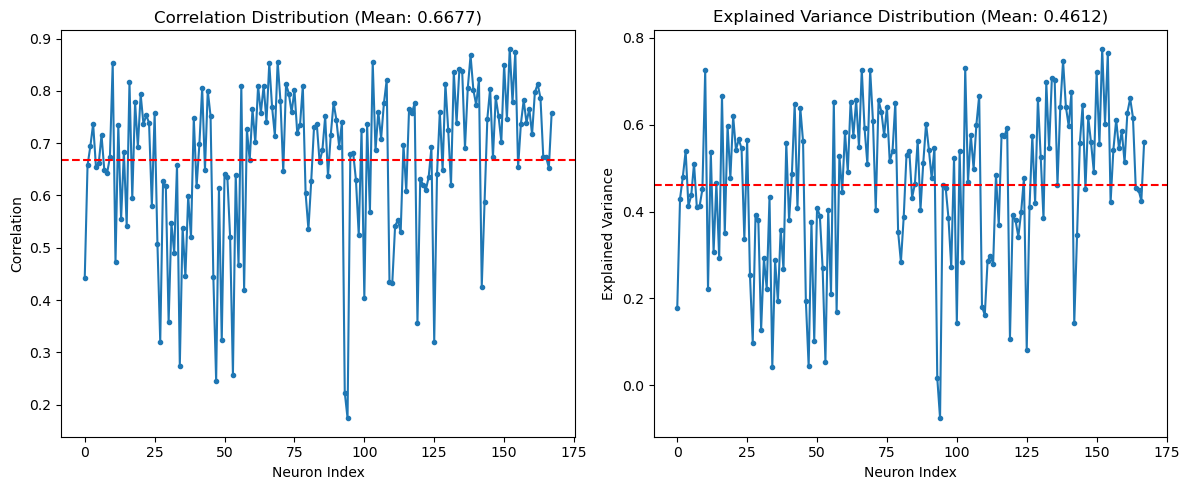

In [27]:
predictions, correlations, exp_variances, mean_correlation, mean_exp_variance = evaluate_model(
    model=resnet50,         
    eval_dataloader=eval_dataloader,  
    y_val=y_val,          
    device=device       
)

In [30]:
hybrid_metrics = {
    'correlations': correlations,
    'exp_variances': exp_variances,
    'mean_correlation': np.mean(correlations),
    'mean_exp_variance': np.mean(exp_variances)
}

filename = "hybrid_metrics.json"
with open(filename, "w") as f:
    json.dump(hybrid_metrics, f, cls=NumpyEncoder, indent=2)